# SANIMA Stock Price Time Series Analysis

This notebook performs comprehensive time series analysis on SANIMA stock data including:
- Data exploration and visualization
- Trend and seasonality analysis
- Stationarity testing
- ARIMA modeling
- Forecasting
- Technical indicators

## 1. Setup and Data Loading

In [1]:
# Install required packages (run this cell first in Google Colab)
!pip install statsmodels pmdarima plotly -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 8.5 MB/s eta 0:00:00


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Statistical and time series libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

In [4]:
# Load the data
df = pd.read_csv('SANIMA.csv')

In [5]:
# Initial data exploration
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nLast few rows:")
print(df.tail())
print("\nData Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (3149, 9)

First few rows:
  published_date   open   high    low  close  per_change  traded_quantity  \
0     2012-04-12  146.0  160.0  148.0  160.0         NaN          12740.0   
1     2012-04-15  160.0  176.0  163.0  176.0       10.00           6574.0   
2     2012-04-16  176.0  191.0  179.0  191.0        8.52           8164.0   
3     2012-04-17  191.0  210.0  181.0  181.0       -5.24           9132.0   
4     2012-04-18  181.0  195.0  165.0  190.0        4.97          19469.0   

   traded_amount  status  
0      1943915.0       0  
1      1152504.0       0  
2      1548134.0       0  
3      1785804.0       0  
4      3558240.0       0  

Last few rows:
     published_date   open   high    low  close  per_change  traded_quantity  \
3144     2026-01-04  315.7  321.0  315.7  318.0        0.28          28559.0   
3145     2026-01-05  322.0  327.0  315.7  327.0        2.83         105874.0   
3146     2026-01-06  330.0  335.0  326.0  333.8        2.08         376792.0 

## 2. Data Preprocessing

In [6]:
# Convert published_date to datetime
df['published_date'] = pd.to_datetime(df['published_date'])

# Sort by date
df = df.sort_values('published_date').reset_index(drop=True)

# Set date as index
df.set_index('published_date', inplace=True)

# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Check for duplicates
print("\nDuplicate rows:", df.index.duplicated().sum())

# Display date range
print(f"\nDate range: {df.index.min()} to {df.index.max()}")
print(f"Total trading days: {len(df)}")

Missing values:
open               0
high               0
low                0
close              0
per_change         1
traded_quantity    0
traded_amount      0
status             0
dtype: int64

Duplicate rows: 11

Date range: 2012-04-12 00:00:00 to 2026-01-08 00:00:00
Total trading days: 3149


In [7]:
# Create additional features
df['daily_return'] = df['close'].pct_change() * 100
df['price_range'] = df['high'] - df['low']
df['year'] = df.index.year
df['month'] = df.index.month
df['day_of_week'] = df.index.dayofweek

# Moving averages
df['MA_7'] = df['close'].rolling(window=7).mean()
df['MA_30'] = df['close'].rolling(window=30).mean()
df['MA_90'] = df['close'].rolling(window=90).mean()

print("Enhanced dataset:")
print(df.head(10))

Enhanced dataset:
                 open   high    low  close  per_change  traded_quantity  \
published_date                                                            
2012-04-12      146.0  160.0  148.0  160.0         NaN          12740.0   
2012-04-15      160.0  176.0  163.0  176.0       10.00           6574.0   
2012-04-16      176.0  191.0  179.0  191.0        8.52           8164.0   
2012-04-17      191.0  210.0  181.0  181.0       -5.24           9132.0   
2012-04-18      181.0  195.0  165.0  190.0        4.97          19469.0   
2012-04-19      190.0  209.0  193.0  202.0        6.32          31297.0   
2012-04-22      202.0  222.0  202.0  222.0        9.90          28005.0   
2012-04-24      222.0  242.0  226.0  242.0        9.01           6186.0   
2012-04-25      242.0  266.0  246.0  266.0        9.92           5101.0   
2012-04-26      266.0  292.0  242.0  292.0        9.77          50478.0   

                traded_amount  status  daily_return  price_range  year  month  \


## 3. Exploratory Data Analysis

In [8]:
# Interactive candlestick chart with Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])

fig.update_layout(
    title='SANIMA Stock Price - Candlestick Chart',
    yaxis_title='Price',
    xaxis_title='Date',
    height=600,
    template='plotly_white'
)

fig.show()

In [9]:
# Close price with moving averages
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index, y=df['close'], name='Close Price', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df.index, y=df['MA_7'], name='7-Day MA', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=df.index, y=df['MA_30'], name='30-Day MA', line=dict(color='green')))
fig.add_trace(go.Scatter(x=df.index, y=df['MA_90'], name='90-Day MA', line=dict(color='red')))

fig.update_layout(
    title='SANIMA Close Price with Moving Averages',
    yaxis_title='Price',
    xaxis_title='Date',
    height=600,
    template='plotly_white'
)

fig.show()

In [10]:
# Volume analysis
fig = make_subplots(rows=2, cols=1,
                    subplot_titles=('Close Price', 'Trading Volume'),
                    row_heights=[0.7, 0.3],
                    vertical_spacing=0.1)

fig.add_trace(go.Scatter(x=df.index, y=df['close'], name='Close Price', line=dict(color='blue')),
              row=1, col=1)

fig.add_trace(go.Bar(x=df.index, y=df['traded_quantity'], name='Volume', marker_color='lightblue'),
              row=2, col=1)

fig.update_xaxes(title_text="Date", row=2, col=1)
fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Volume", row=2, col=1)

fig.update_layout(height=700, title_text="Price and Volume Analysis", template='plotly_white')
fig.show()

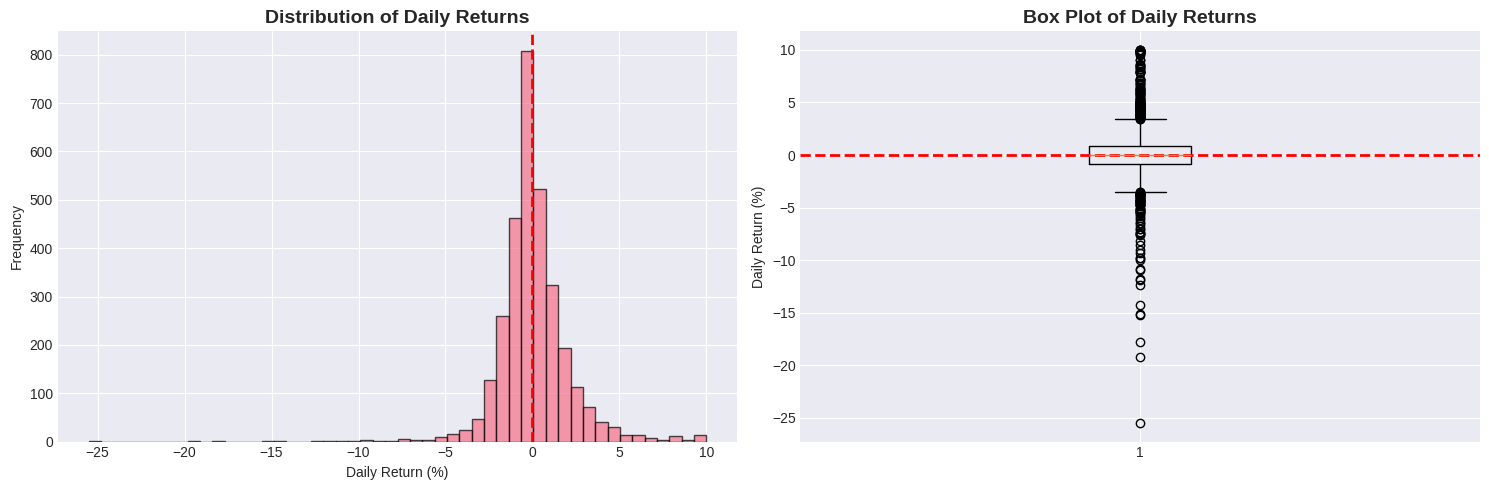

Mean daily return: 0.0483%
Std daily return: 2.1923%
Skewness: -0.7733
Kurtosis: 15.2270


In [11]:
# Distribution of daily returns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df['daily_return'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Daily Returns', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Daily Return (%)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)

# Box plot
axes[1].boxplot(df['daily_return'].dropna())
axes[1].set_title('Box Plot of Daily Returns', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Daily Return (%)')
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

print(f"Mean daily return: {df['daily_return'].mean():.4f}%")
print(f"Std daily return: {df['daily_return'].std():.4f}%")
print(f"Skewness: {df['daily_return'].skew():.4f}")
print(f"Kurtosis: {df['daily_return'].kurtosis():.4f}")

In [12]:
# Yearly analysis
yearly_stats = df.groupby('year').agg({
    'close': ['first', 'last', 'min', 'max', 'mean'],
    'traded_quantity': 'sum',
    'traded_amount': 'sum'
}).round(2)

yearly_stats.columns = ['_'.join(col).strip() for col in yearly_stats.columns.values]
yearly_stats['yearly_return_%'] = ((yearly_stats['close_last'] - yearly_stats['close_first']) /
                                     yearly_stats['close_first'] * 100).round(2)

print("Yearly Statistics:")
print(yearly_stats)

Yearly Statistics:
      close_first  close_last  close_min  close_max  close_mean  \
year                                                              
2012        160.0       280.0      160.0     296.00      223.92   
2013        273.0       509.0      231.0     537.00      278.59   
2014        485.0       536.0      443.0     652.00      518.80   
2015        526.0       659.0      458.0     850.00      619.31   
2016        661.0       520.0      515.0     929.00      731.11   
2017        528.0       334.0      329.0     574.00      429.96   
2018        342.0       309.0      299.0     381.00      335.38   
2019        308.0       313.0      290.0     365.00      326.80   
2020        313.0       321.0      305.0     424.00      339.67   
2021        329.0       354.0      322.2     562.90      425.53   
2022        363.0       240.0      223.0     396.00      290.45   
2023        239.0       254.0      228.6     306.00      256.12   
2024        252.0       299.9      230.0   

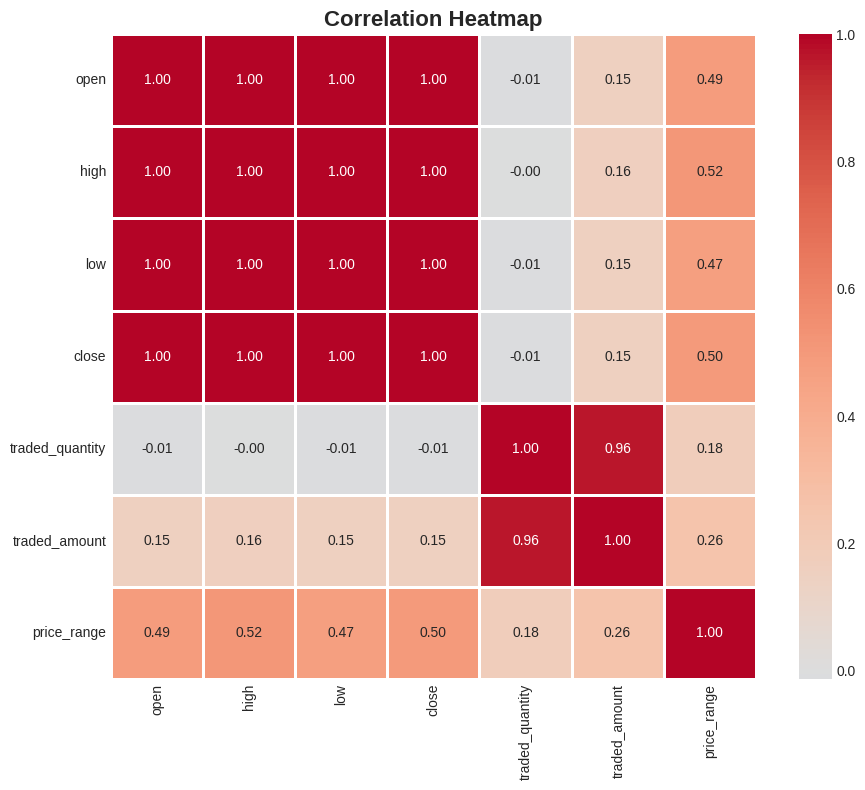

In [13]:
# Correlation heatmap
numeric_cols = ['open', 'high', 'low', 'close', 'traded_quantity', 'traded_amount', 'price_range']
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, fmt='.2f')
plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Time Series Decomposition

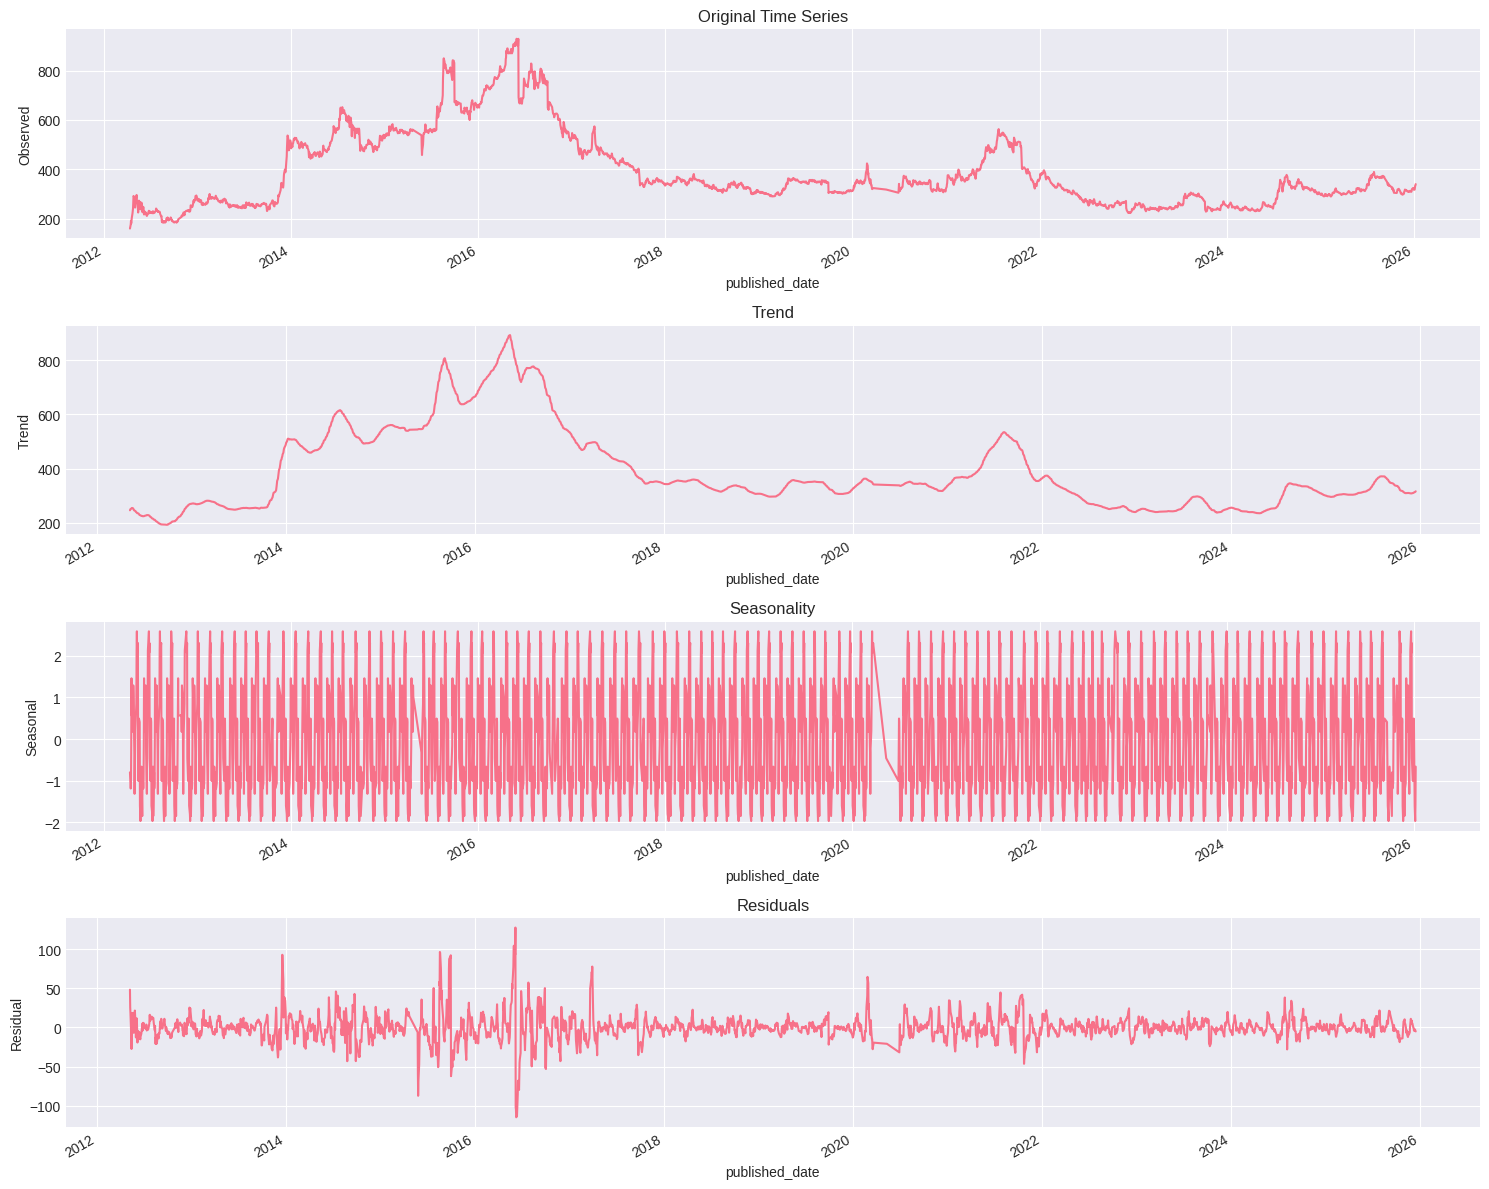

In [14]:
# Decompose the time series (additive model)
# Remove any NaN values for decomposition
close_series = df['close'].dropna()

# Use a period of 30 days (approximately monthly seasonality)
decomposition = seasonal_decompose(close_series, model='additive', period=30)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

decomposition.observed.plot(ax=axes[0], title='Original Time Series')
axes[0].set_ylabel('Observed')

decomposition.trend.plot(ax=axes[1], title='Trend')
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], title='Seasonality')
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3], title='Residuals')
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

## 5. Stationarity Testing

In [15]:
# Augmented Dickey-Fuller test
def adf_test(series, title=''):
    """
    Perform Augmented Dickey-Fuller test
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF Test Statistic', 'p-value', 'Lags Used', 'Number of Observations']
    output = pd.Series(result[0:4], index=labels)

    for key, value in result[4].items():
        output[f'Critical Value ({key})'] = value

    print(output.to_string())

    if result[1] <= 0.05:
        print("\n=> Strong evidence against the null hypothesis")
        print("=> Reject the null hypothesis")
        print("=> Data is STATIONARY")
    else:
        print("\n=> Weak evidence against the null hypothesis")
        print("=> Fail to reject the null hypothesis")
        print("=> Data is NON-STATIONARY")
    print('-' * 80)

# Test original series
adf_test(df['close'], 'Close Price')

# Test first difference
df['close_diff'] = df['close'].diff()
adf_test(df['close_diff'].dropna(), 'First Difference of Close Price')

Augmented Dickey-Fuller Test: Close Price
ADF Test Statistic          -2.179241
p-value                      0.213866
Lags Used                    0.000000
Number of Observations    3148.000000
Critical Value (1%)         -3.432429
Critical Value (5%)         -2.862459
Critical Value (10%)        -2.567259

=> Weak evidence against the null hypothesis
=> Fail to reject the null hypothesis
=> Data is NON-STATIONARY
--------------------------------------------------------------------------------
Augmented Dickey-Fuller Test: First Difference of Close Price
ADF Test Statistic         -54.852098
p-value                      0.000000
Lags Used                    0.000000
Number of Observations    3147.000000
Critical Value (1%)         -3.432430
Critical Value (5%)         -2.862459
Critical Value (10%)        -2.567259

=> Strong evidence against the null hypothesis
=> Reject the null hypothesis
=> Data is STATIONARY
-------------------------------------------------------------------------

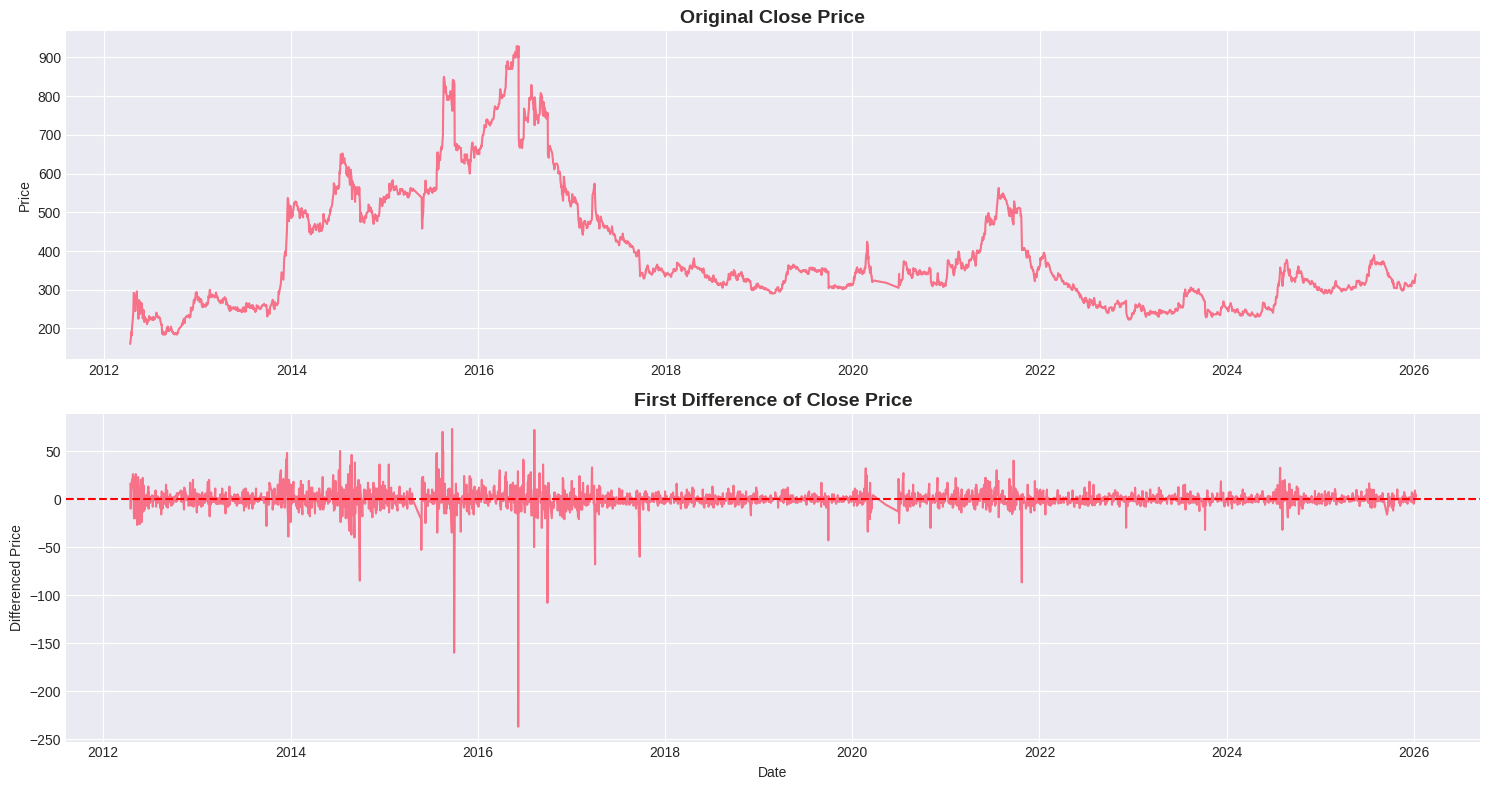

In [16]:
# Visualize original vs differenced series
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Original series
axes[0].plot(df.index, df['close'])
axes[0].set_title('Original Close Price', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price')

# Differenced series
axes[1].plot(df.index, df['close_diff'])
axes[1].set_title('First Difference of Close Price', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Differenced Price')
axes[1].set_xlabel('Date')
axes[1].axhline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

## 6. ACF and PACF Analysis

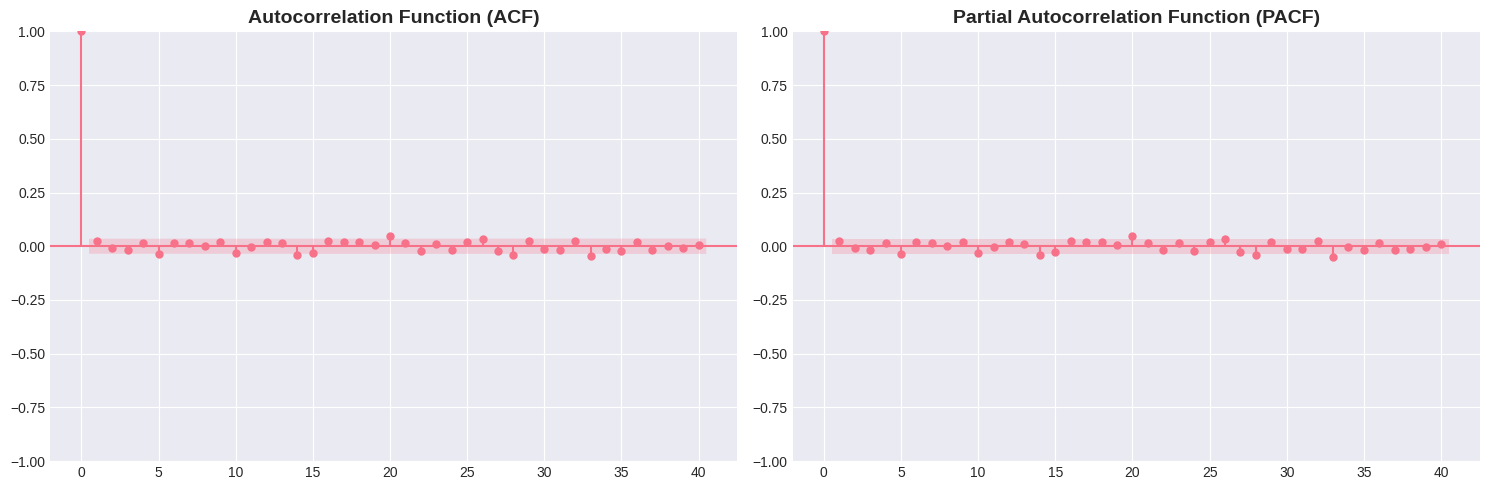

In [17]:
# ACF and PACF plots for differenced series
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF plot
plot_acf(df['close_diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=14, fontweight='bold')

# PACF plot
plot_pacf(df['close_diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Train-Test Split

Training set size: 2519
Test set size: 630
Training period: 2012-04-12 00:00:00 to 2023-04-10 00:00:00
Test period: 2023-04-11 00:00:00 to 2026-01-08 00:00:00


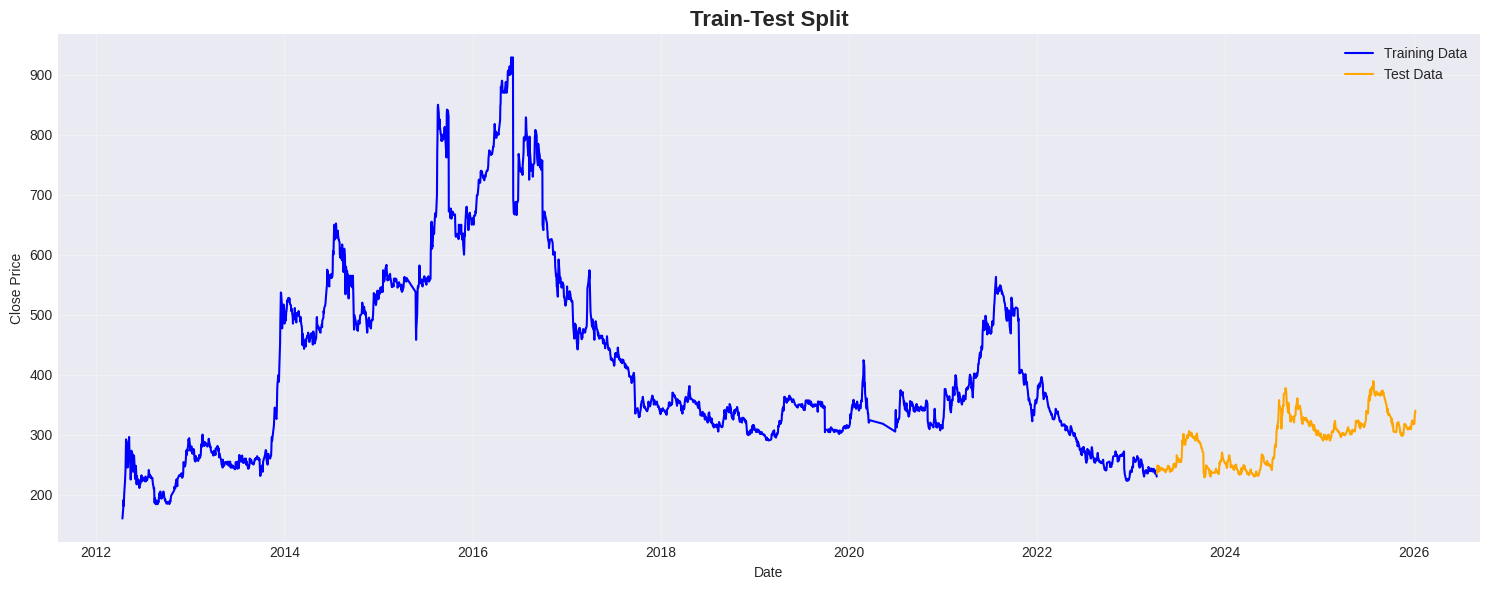

In [18]:
# Split data into train and test sets (80-20 split)
train_size = int(len(df) * 0.8)
train_data = df['close'][:train_size]
test_data = df['close'][train_size:]

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Training period: {train_data.index[0]} to {train_data.index[-1]}")
print(f"Test period: {test_data.index[0]} to {test_data.index[-1]}")

# Visualize split
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Test Data', color='orange')
plt.title('Train-Test Split', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. ARIMA Model - Auto Selection

In [19]:
# Auto ARIMA to find best parameters
print("Finding optimal ARIMA parameters...")

auto_model = auto_arima(
    train_data,
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    d=None,  # Let auto_arima determine d
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True
)

print("\n" + "="*80)
print("Best ARIMA Model Summary:")
print("="*80)
print(auto_model.summary())

Finding optimal ARIMA parameters...
This may take a few minutes...

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19291.268, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19292.082, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19292.057, Time=1.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19289.283, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19293.995, Time=3.92 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 6.103 seconds

Best ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2519
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -9643.642
Date:                Sun, 11 Jan 2026   AIC                          19289.283
Time:                        07:02:46   BIC                          19295.114
Sample:                             0   HQIC           

## 9. ARIMA Model Training and Forecasting

In [20]:
# Get the best order from auto_arima
best_order = auto_model.order
print(f"Best ARIMA order: {best_order}")

# Fit ARIMA model with best parameters
model = ARIMA(train_data, order=best_order)
fitted_model = model.fit()

print("\nModel Summary:")
print(fitted_model.summary())

Best ARIMA order: (0, 1, 0)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.




Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 2519
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -9643.642
Date:                Sun, 11 Jan 2026   AIC                          19289.283
Time:                        07:02:55   BIC                          19295.114
Sample:                             0   HQIC                         19291.399
                               - 2519                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       124.1997      0.473    262.652      0.000     123.273     125.127
Ljung-Box (L1) (Q):                   1.19   Jarque-Bera (JB):           1227326.99
Prob(Q):                       

In [21]:
# Make predictions on test set
forecast_steps = len(test_data)
forecast = fitted_model.forecast(steps=forecast_steps)

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'Date': test_data.index,
    'Actual': test_data.values,
    'Predicted': forecast
})

print("Forecast Results:")
print(forecast_df.head(10))

Forecast Results:
           Date  Actual  Predicted
2519 2023-04-11   234.9      230.0
2520 2023-04-12   246.8      230.0
2521 2023-04-13   248.5      230.0
2522 2023-04-16   246.0      230.0
2523 2023-04-17   243.0      230.0
2524 2023-04-18   238.2      230.0
2525 2023-04-19   247.4      230.0
2526 2023-04-20   245.0      230.0
2527 2023-04-23   242.1      230.0
2528 2023-04-24   240.0      230.0


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [23]:
# Calculate performance metrics
# Ensure forecast has the same index as test_data for accurate alignment
forecast = pd.Series(forecast.values, index=test_data.index)

mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, forecast)
mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100

print("Model Performance Metrics:")
print("="*50)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Model Performance Metrics:
Mean Squared Error (MSE): 5396.65
Root Mean Squared Error (RMSE): 73.46
Mean Absolute Error (MAE): 60.84
Mean Absolute Percentage Error (MAPE): 19.32%


In [24]:
# Visualize predictions vs actual
fig = go.Figure()

# Training data
fig.add_trace(go.Scatter(
    x=train_data.index,
    y=train_data,
    mode='lines',
    name='Training Data',
    line=dict(color='blue')
))

# Actual test data
fig.add_trace(go.Scatter(
    x=test_data.index,
    y=test_data,
    mode='lines',
    name='Actual',
    line=dict(color='green')
))

# Predicted values
fig.add_trace(go.Scatter(
    x=forecast_df['Date'],
    y=forecast_df['Predicted'],
    mode='lines',
    name='Predicted',
    line=dict(color='red', dash='dash')
))

fig.update_layout(
    title='ARIMA Model: Actual vs Predicted',
    xaxis_title='Date',
    yaxis_title='Close Price',
    height=600,
    template='plotly_white',
    hovermode='x unified'
)

fig.show()

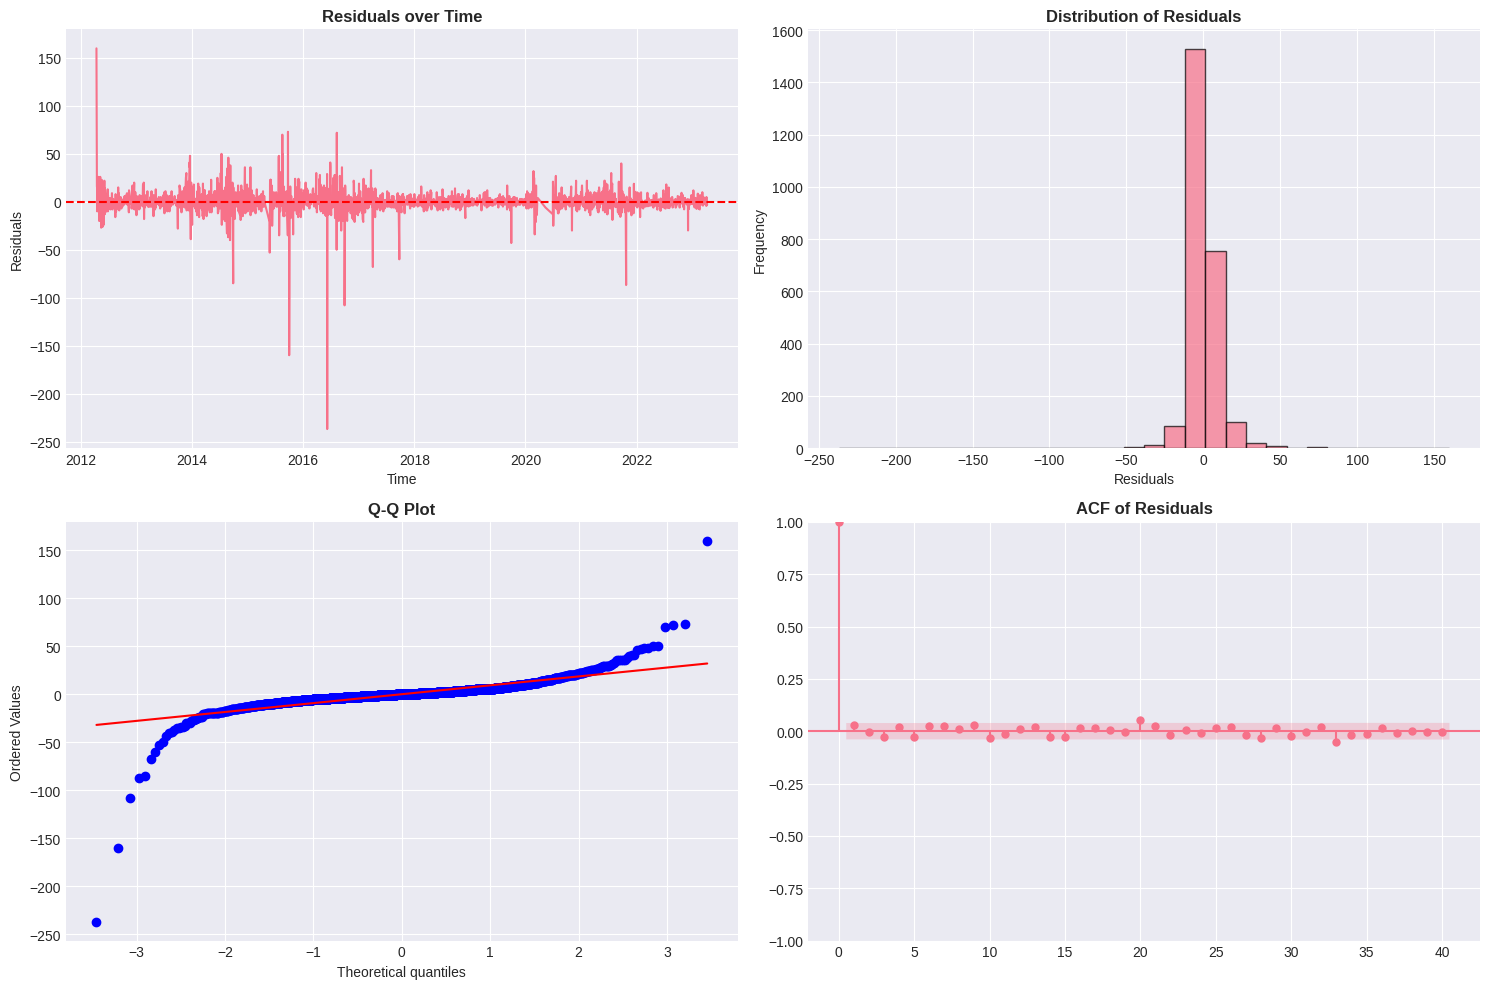

In [25]:
# Residual analysis
residuals = fitted_model.resid

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Residuals plot
axes[0, 0].plot(residuals)
axes[0, 0].set_title('Residuals over Time', fontweight='bold')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].axhline(0, color='red', linestyle='--')

# Histogram of residuals
axes[0, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Residuals', fontweight='bold')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot', fontweight='bold')

# ACF of residuals
plot_acf(residuals, lags=40, ax=axes[1, 1])
axes[1, 1].set_title('ACF of Residuals', fontweight='bold')

plt.tight_layout()
plt.show()

## 10. Future Forecasting

In [26]:
# Retrain model on entire dataset
final_model = ARIMA(df['close'], order=best_order)
final_fitted = final_model.fit()

# Forecast next 30 days
future_steps = 30
future_forecast = final_fitted.forecast(steps=future_steps)

# Get confidence intervals
forecast_result = final_fitted.get_forecast(steps=future_steps)
forecast_ci = forecast_result.conf_int()

# Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='D')

# Create forecast dataframe
future_df = pd.DataFrame({
    'Date': future_dates,
    'Forecast': future_forecast,
    'Lower_CI': forecast_ci.iloc[:, 0],
    'Upper_CI': forecast_ci.iloc[:, 1]
})

print(f"\nForecast for next {future_steps} days:")
print(future_df)


Forecast for next 30 days:
           Date  Forecast    Lower_CI    Upper_CI
3149 2026-01-09     340.0  319.964708  360.035292
3150 2026-01-10     340.0  311.665819  368.334181
3151 2026-01-11     340.0  305.297857  374.702143
3152 2026-01-12     340.0  299.929417  380.070583
3153 2026-01-13     340.0  295.199726  384.800274
3154 2026-01-14     340.0  290.923759  389.076241
3155 2026-01-15     340.0  286.991601  393.008399
3156 2026-01-16     340.0  283.331638  396.668362
3157 2026-01-17     340.0  279.894125  400.105875
3158 2026-01-18     340.0  276.642845  403.357155
3159 2026-01-19     340.0  273.550455  406.449545
3160 2026-01-20     340.0  270.595714  409.404286
3161 2026-01-21     340.0  267.761729  412.238271
3162 2026-01-22     340.0  265.034803  414.965197
3163 2026-01-23     340.0  262.403649  417.596351
3164 2026-01-24     340.0  259.858834  420.141166
3165 2026-01-25     340.0  257.392377  422.607623
3166 2026-01-26     340.0  254.997457  425.002543
3167 2026-01-27     34

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Predicti

In [27]:
# Visualize future forecast with confidence intervals
fig = go.Figure()

# Historical data (last 180 days for clarity)
historical_plot = df['close'][-180:]
fig.add_trace(go.Scatter(
    x=historical_plot.index,
    y=historical_plot,
    mode='lines',
    name='Historical Data',
    line=dict(color='blue')
))

# Forecast
fig.add_trace(go.Scatter(
    x=future_df['Date'],
    y=future_df['Forecast'],
    mode='lines',
    name='Forecast',
    line=dict(color='red')
))

# Confidence interval
fig.add_trace(go.Scatter(
    x=future_df['Date'].tolist() + future_df['Date'].tolist()[::-1],
    y=future_df['Upper_CI'].tolist() + future_df['Lower_CI'].tolist()[::-1],
    fill='toself',
    fillcolor='rgba(255,0,0,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='95% Confidence Interval',
    showlegend=True
))

fig.update_layout(
    title=f'SANIMA Stock Price Forecast - Next {future_steps} Days',
    xaxis_title='Date',
    yaxis_title='Close Price',
    height=600,
    template='plotly_white',
    hovermode='x unified'
)

fig.show()

## 11. Technical Indicators

In [28]:
# Calculate additional technical indicators

# RSI (Relative Strength Index)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_rsi(df['close'])

# MACD (Moving Average Convergence Divergence)
exp1 = df['close'].ewm(span=12, adjust=False).mean()
exp2 = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp1 - exp2
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Bollinger Bands
df['BB_middle'] = df['close'].rolling(window=20).mean()
bb_std = df['close'].rolling(window=20).std()
df['BB_upper'] = df['BB_middle'] + (bb_std * 2)
df['BB_lower'] = df['BB_middle'] - (bb_std * 2)

print("Technical indicators calculated successfully!")

Technical indicators calculated successfully!


In [29]:
# Plot Bollinger Bands
fig = go.Figure()

plot_data = df[-365:]  # Last year

fig.add_trace(go.Scatter(x=plot_data.index, y=plot_data['close'], name='Close Price', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=plot_data.index, y=plot_data['BB_upper'], name='Upper Band', line=dict(color='red', dash='dash')))
fig.add_trace(go.Scatter(x=plot_data.index, y=plot_data['BB_middle'], name='Middle Band', line=dict(color='gray', dash='dash')))
fig.add_trace(go.Scatter(x=plot_data.index, y=plot_data['BB_lower'], name='Lower Band', line=dict(color='green', dash='dash')))

fig.update_layout(
    title='Bollinger Bands',
    xaxis_title='Date',
    yaxis_title='Price',
    height=600,
    template='plotly_white'
)

fig.show()

In [30]:
# Plot RSI
fig = make_subplots(rows=2, cols=1,
                    subplot_titles=('Close Price', 'RSI'),
                    row_heights=[0.7, 0.3],
                    vertical_spacing=0.1)

plot_data = df[-365:]  # Last year

fig.add_trace(go.Scatter(x=plot_data.index, y=plot_data['close'], name='Close Price', line=dict(color='blue')),
              row=1, col=1)

fig.add_trace(go.Scatter(x=plot_data.index, y=plot_data['RSI'], name='RSI', line=dict(color='purple')),
              row=2, col=1)

# Add overbought/oversold lines
fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1)
fig.add_hline(y=30, line_dash="dash", line_color="green", row=2, col=1)

fig.update_xaxes(title_text="Date", row=2, col=1)
fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="RSI", row=2, col=1)

fig.update_layout(height=700, title_text="RSI Indicator", template='plotly_white', showlegend=False)
fig.show()

## 12. Summary and Conclusions

In [32]:
# Generate summary statistics
print("="*80)
print("SANIMA STOCK ANALYSIS SUMMARY")
print("="*80)

print("\n1. DATA OVERVIEW:")
print(f"   - Total trading days: {len(df)}")
print(f"   - Date range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
print(f"   - Current price: {df['close'].iloc[-1]:.2f}")
print(f"   - All-time high: {df['close'].max():.2f}")
print(f"   - All-time low: {df['close'].min():.2f}")

print("\n2. RETURNS ANALYSIS:")
print(f"   - Mean daily return: {df['daily_return'].mean():.4f}%")
print(f"   - Volatility (std): {df['daily_return'].std():.4f}%")
print(f"   - Total return: {((df['close'].iloc[-1] - df['close'].iloc[0]) / df['close'].iloc[0] * 100):.2f}%")

print("\n3. MODEL PERFORMANCE:")
print(f"   - Best ARIMA order: {best_order}")
print(f"   - RMSE: {rmse:.2f}")
print(f"   - MAE: {mae:.2f}")
print(f"   - MAPE: {mape:.2f}%")

print("\n4. CURRENT TECHNICAL INDICATORS:")
print(f"   - RSI: {df['RSI'].iloc[-1]:.2f}")
if df['RSI'].iloc[-1] > 70:
    print("     (Overbought territory)")
elif df['RSI'].iloc[-1] < 30:
    print("     (Oversold territory)")
else:
    print("     (Neutral)")

print(f"   - MACD: {df['MACD'].iloc[-1]:.2f}")
print(f"   - Signal Line: {df['Signal_Line'].iloc[-1]:.2f}")

print("\n5. FORECAST:")
print(f"   - Next day forecast: {future_df['Forecast'].iloc[0]:.2f}")
print(f"   - 7-day forecast: {future_df['Forecast'].iloc[6]:.2f}")
print(f"   - 30-day forecast: {future_df['Forecast'].iloc[-1]:.2f}")

print("\n" + "="*80)

SANIMA STOCK ANALYSIS SUMMARY

1. DATA OVERVIEW:
   - Total trading days: 3149
   - Date range: 2012-04-12 to 2026-01-08
   - Current price: 340.00
   - All-time high: 929.00
   - All-time low: 160.00

2. RETURNS ANALYSIS:
   - Mean daily return: 0.0483%
   - Volatility (std): 2.1923%
   - Total return: 112.50%

3. MODEL PERFORMANCE:
   - Best ARIMA order: (0, 1, 0)
   - RMSE: 73.46
   - MAE: 60.84
   - MAPE: 19.32%

4. CURRENT TECHNICAL INDICATORS:
   - RSI: 75.67
     (Overbought territory)
   - MACD: 5.63
   - Signal Line: 2.95

5. FORECAST:
   - Next day forecast: 340.00
   - 7-day forecast: 340.00
   - 30-day forecast: 340.00

